In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
modelpath = '/eos/uscms/store/user/ekoenig/weaver/analysis/models/exp_sixb_diff_aggr/feynnet_ranker_6b/20230728_59b53a4bde5e7da6eb8e6aa522b30859_ranger_lr0.0047_batch2000_withbkg'

In [4]:
sigfile = '/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag_4b/Official_NMSSM/NMSSM_XToYHTo6B_MX-1000_MY-250_TuneCP5_13TeV-madgraph-pythia8/ntuple.root'

In [5]:
signal = ObjIter([Tree(sigfile)])

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


In [9]:
load_feynnet = sixb.f_load_feynnet_assignment(modelpath)

In [11]:
signal.apply(load_feynnet,report=True)

f_load_feynnet_assignment: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


[None]

In [15]:
fc.sixb = fc.FileCollection('/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag_4b/')

In [34]:
f_qcd = fc.sixb.QCD_B_List

In [35]:
f_tt = list(map(lambda f : f.replace('ntuple_0','ntuple'), fc.sixb.TTJets))

In [36]:
f_signal = [ f'{d}/ntuple.root' for d in fc.sixb.Official_NMSSM.ls if d.endswith('pythia8') ]

In [40]:
re_mxmy = re.compile(r'.*MX-(\d+)_MY-(\d+).*')

def get_mxmy(fname):
    m = re_mxmy.match(fname)
    if m:
        return int(m.group(1)), int(m.group(2))
    return None



In [70]:
masses = np.array(list(map(get_mxmy, f_signal)))
mask = np.all(( (masses / 100) - (masses // 100) ) == 0, axis=1)
mask &= masses[:,0] <= 1400

selected = masses[mask]
mask.sum()

53

(<Figure size 650x650 with 1 Axes>, <AxesSubplot:>)

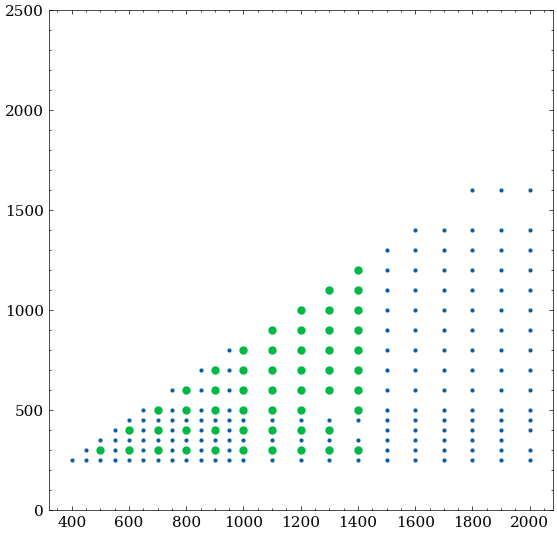

In [68]:
graph_array(*masses.T, xlabel='MX', ylabel='MY', g_linestyle='none', g_marker='o', g_markersize=2)
graph_array(*selected.T, g_linestyle='none', g_marker='o', g_markersize=5, figax='same')